In [99]:
import sys
sys.path.insert(0, r'C:\Users\buzga\Desktop\School\Reaserch\Langone\ML_RA_EHR\DataModule')
sys.path.insert(0, r'C:\Users\buzga\Desktop\School\Reaserch\Langone\ML_RA_EHR')
from sklearn import linear_model
from sklearn import ensemble
from sklearn import svm
import matplotlib.pyplot as plt
import Data_Preparation
import evaluate 
import xgboost as xgb




In [100]:
## importing data. 
path=r'C:\Users\buzga\Desktop\School\Reaserch\Langone\ML_RA_EHR\Dataset'
df = Data_Preparation.CoronnaCERTAINDataset(
    library_root=path,
    challenge="classification", #option: regression, classification, two_stage
    dataset='CORRONA CERTAIN', 
    process_approach='SC', #option: KVB, SC
    imputation='KNN', #option: SimpleFill, KNN, SoftImpute, BiScaler, NuclearNormMinimization, IterativeImputer, IterativeSVD
    patient_group='bionaive TNF', #option: "all", "bioexp nTNF", "bionaive TNF", "bionaive orencia", "KVB"
    drug_group='all', #option: "all", "actemra", "cimzia", "enbrel", "humira", "orencia", "remicade", "rituxan", "simponi"
    time_points=(0,3), 
    train_test_rate=0.8,
    save_csv=False, 
    random_state=2022)

train, train_loc = df.get_train()
test, test_loc = df.get_test()
X_train = train.iloc[:,:-1]
X_train=X_train.drop(["DAS28_CRP_3M"],axis=1)
y_train = train.iloc[:,-1]
X_test = test.iloc[:,:-1]
X_test=X_test.drop(["DAS28_CRP_3M"],axis=1)
y_test = test.iloc[:,-1]


feature engineering, drop columns due to 70% missing value: Index(['smkyrs', 'numcigs', 'rfstatus_impute', 'ccpstatus_impute',
       'statin_use'],
      dtype='object')
Imputing row 1/1498 with 0 missing, elapsed time: 0.379
Imputing row 101/1498 with 1 missing, elapsed time: 0.380
Imputing row 201/1498 with 0 missing, elapsed time: 0.381
Imputing row 301/1498 with 0 missing, elapsed time: 0.382
Imputing row 401/1498 with 0 missing, elapsed time: 0.382
Imputing row 501/1498 with 1 missing, elapsed time: 0.383
Imputing row 601/1498 with 0 missing, elapsed time: 0.383
Imputing row 701/1498 with 0 missing, elapsed time: 0.383
Imputing row 801/1498 with 0 missing, elapsed time: 0.384
Imputing row 901/1498 with 0 missing, elapsed time: 0.384
Imputing row 1001/1498 with 1 missing, elapsed time: 0.385
Imputing row 1101/1498 with 0 missing, elapsed time: 0.386
Imputing row 1201/1498 with 0 missing, elapsed time: 0.386
Imputing row 1301/1498 with 0 missing, elapsed time: 0.387
Imputing row 14

In [101]:
import numpy as np
def map_numeric(input):
    true=[]
    for i in input:
        if(i=="Good"):
            true.append(0)
        elif(i=="Moderate"):
            true.append(1)
        else:
            true.append(2)
    return np.array(true)
def map_to_catagory(preds):
    true=[]
    for i in preds:
        if(i==0):
            true.append("Good")
        elif(i==1):
            true.append("Moderate")
        else:
            true.append("No Response")
    return np.array(true)





In [102]:
## start with logistic regression. 
log_model=linear_model.LogisticRegression()
log_model=log_model.fit(X_train,y_train)
log_preds=log_model.predict(X_test)


random_forrst=ensemble.RandomForestClassifier(n_estimators=1000)
random_forrst=random_forrst.fit(X_train,y_train)
random_forrst_preds=random_forrst.predict(X_test)


### this wants us to convert class lables to 0,1,2

train_numeric=map_numeric(y_train)
xgboost = xgb.XGBClassifier()
xgboost.fit(X_train, train_numeric)
xgboost_preds = xgboost.predict(X_test)
xgboost_preds=map_to_catagory(xgboost_preds)


estimators = [('lr',linear_model.RidgeCV()),('svr', svm.LinearSVR(random_state=42))]
stacking =ensemble.StackingRegressor(estimators=estimators,
final_estimator=ensemble.RandomForestRegressor(n_estimators=10,random_state=42))
stacking=stacking.fit(X_train, train_numeric)
stacking_preds=stacking.predict(X_test)
stacking_preds=map_to_catagory(stacking_preds)


c:\Users\buzga\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\buzga\anaconda3\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\buzga\anaconda3\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\buzga\anaconda3\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of

In [103]:

aml = evaluate.AutoBuild(seed=1, project_name="EHR_RA_SC",challenge="classification")

aml.evaluate("Logistic", test, log_preds)
aml.evaluate("Random Forrest", test, random_forrst_preds)
aml.evaluate("xgboost", test, xgboost_preds)
aml.evaluate("Stacking", test, stacking_preds)
classification = aml.leaderboard()

In [104]:
classification

,model,Accuracy,F1-Score
0,Logistic,0.476744,0.457450
1,Random Forrest,0.511628,0.491592
2,xgboost,0.488372,0.483946
3,Stacking,0.337209,0.257359


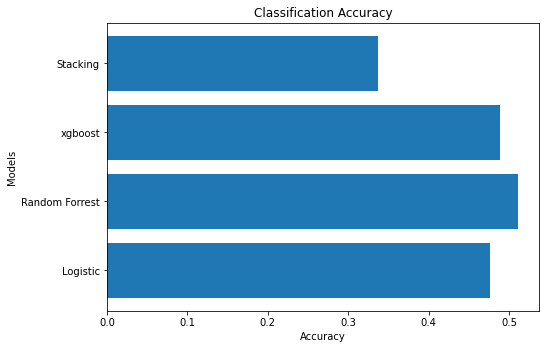

In [105]:
aml.plot_results('classification',metics="Accuracy")